In [1]:
import os
import re
from cv2 import exp
import numpy as np
import matplotlib.pyplot as plt
from ArUCo_Markers_Pose import pose_data, pose_estimation
from Utilities.Helpers import toTime
import time
import json
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from experiments import get_all_input
from datetime import datetime, timedelta
import pandas as pd
import plotly.express as px
import heapq
from DataCleaner import clean
import webbrowser
import math
from collections import defaultdict

from scipy.signal import butter, filtfilt
from scipy import integrate
import sys
!{sys.executable} -m pip install dash

import dash
from dash import dcc, html, Input, Output
import plotly.colors as pc

print(os.getcwd())
debug = True
fps = 30


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\me\Documents\GitHub\EDMO\EDMO_AI


In [2]:
def compute_speed(exp_edmo_poses:dict[int, dict[int, list]], filepath):
    '''
        Speed: units=meter per frame, sum of speed over the course of one experiment
        abs_speed: units=meter per frame, averaged sum of absolute speed over the course of one experiment
        Movement: units=meters, maximum displacement over the course of one experiment
    '''
    exp_edmo_movement = {}
    x_all_diff, y_all_diff, z_all_diff = [], [], []
    for exp_nb, positions in exp_edmo_poses.items():
        x_speed, y_speed, z_speed = 0.0, 0.0, 0.0
        per_frame_x_speed, per_frame_y_speed, per_frame_z_speed = 0.0, 0.0, 0.0
        
        frame_keys = list(positions.keys())
        nb_frames = frame_keys[-1] - frame_keys[0] + 1
        previous_el = None
        for i, pos_frame in enumerate(positions.items()):
            if previous_el is None:
                previous_el = pos_frame
                continue
            frame_diff = pos_frame[0] - previous_el[0]

            x, y, z = previous_el[1]
            x_next, y_next, z_next = pos_frame[1]
            x_diff = (x_next-x)/frame_diff
            y_diff = (y_next-y)/frame_diff
            z_diff = (z_next-z)/frame_diff
            
            threshold = 0.01
            if abs(x_diff) > threshold or abs(y_diff) > threshold:
                previous_el = pos_frame
                nb_frames -= frame_diff
                continue
            x_all_diff.append(x_diff)
            y_all_diff.append(y_diff)
            z_all_diff.append(z_diff)
            
            x_speed += x_diff
            y_speed += y_diff
            z_speed += z_diff
            
            per_frame_x_speed += abs(x_diff)
            per_frame_y_speed += abs(y_diff)
            per_frame_z_speed += abs(z_diff)
            
            previous_el = pos_frame
            
        per_frame_x_speed = x_speed/nb_frames
        per_frame_y_speed = y_speed/nb_frames
        per_frame_z_speed = z_speed/nb_frames
        global_speed = float(np.sqrt(x_speed**2 + y_speed**2 + z_speed**2))    
        xy_speed = float(np.sqrt(x_speed**2 + y_speed**2))
        per_frame_global_speed = float(np.sqrt(per_frame_x_speed**2 + per_frame_y_speed**2 + per_frame_z_speed**2))            
        per_frame_xy_speed = float(np.sqrt(per_frame_x_speed**2 + per_frame_y_speed**2))     
               
        exp_edmo_movement[exp_nb] =[x_speed, y_speed, z_speed, global_speed, xy_speed,\
                                    per_frame_x_speed, per_frame_y_speed, per_frame_z_speed, per_frame_global_speed, per_frame_xy_speed, exp_nb]
        f = open(f"{filepath}/speed_data.log", "w")
        json.dump(exp_edmo_movement, f)
    n = 3
    print(f'avg x displacement: {sum(x_all_diff) / len(x_all_diff)}, max : {heapq.nlargest(n, x_all_diff)}, min : {heapq.nsmallest(n, x_all_diff)}')
    print(f'avg y displacement: {sum(y_all_diff) / len(y_all_diff)}, max : {heapq.nlargest(n, y_all_diff)}, min : {heapq.nsmallest(n,y_all_diff)}')
    print(f'avg z displacement: {sum(z_all_diff) / len(z_all_diff)}, max : {heapq.nlargest(n, z_all_diff)}, min : {heapq.nsmallest(n,z_all_diff)}')
    return exp_edmo_movement

In [3]:
def merge_parameter_data(all_input, exp_edmo_movement): 
    '''
    Where speed_type is an integer:
    1,2,3 : x,y,z speed
    4,5 : xyz speed, xy speed
    6,7,8 : x,y,z average per frame speed
    9, 10 : xyz, xy average per frame speed
    '''
    global plot_data
    amp1, amp2, off1, off2, phb_diff, speeds = [], [], [], [], [], {}
    for i in range(11): 
        speeds[i] = []
    for frame, speed in exp_edmo_movement.items():
        inputs = all_input[frame] # (freq, (amp0, amp1), (off0, off1), (phb0, phb1))
        amp1.append(inputs[1][0])
        amp2.append(inputs[1][1])
        off1.append(inputs[2][0])
        off2.append(inputs[2][1])
        phb_diff.append(abs(inputs[3][0]-inputs[3][1]))
        for i in range(11): 
            speeds[i].append(speed[i]) 
        
    data = pd.DataFrame({
        'Amp_motor_1': amp1,
        'Amp_motor_2': amp2,
        'Offset_motor_1': off1,
        'Offset_motor_2': off2,
        'Phase_difference': phb_diff,
        'x speed' : speeds[0],
        'y speed' : speeds[1],
        'z speed' : speeds[2],
        'xyz speed' : speeds[3],
        'xy speed' : speeds[4],
        'x frame speed' : speeds[5],
        'y frame speed' : speeds[6],
        'z frame speed' : speeds[7],
        'xyz frame speed' : speeds[8],
        'xy frame speed' : speeds[9],
        'exp nb' : speeds[10]
    })
    
    plot_data = pd.concat([plot_data, data], ignore_index=True) if plot_data is not None else data  
    return data
    

In [4]:
def toDatetime(time):
    t = datetime.strptime(time,"%H:%M:%S.%f")
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)

def find_exp_time_frames(input, motors_data):
    # Get the range of motor data that corresponds to the input 
    start_ends = []
    for i, motor in enumerate(motors_data):
        start_ends.append([])
        start_end = start_ends[i]
        j = 1
        while j < len(motor):
            motor_data = motor[j]
            data = motor_data.split(',')
            freq = abs(input[0] - float(data[1]))
            amp = abs(input[1][i] - float(data[2]))
            off = abs(input[2][i] - float(data[3]))        
            phb = abs(input[3][i] - float(data[4]))
            
            # start = when the motor data is close enough to the input
            if not len(start_end)%2:
                if freq < 0.1 and amp < 2 and off < 3 and phb < 0.07:
                    start_end.append(j)
                    
             # end = when the motor data is not close enough to the input anymore
            if len(start_end)%2:
                if freq > 0.1 or amp > 2 or off > 3 or phb > 0.07:
                    start_j = [start_end[i] for i in range(0, len(start_end)-1, 2)]
                    
                    if j - start_end[-1] <= 10: # ignore motor transitions (end and start too close)
                        del start_end[-1]
                        continue
                    elif len(start_j) > 0 and all(j < sj for sj in start_j): # ignore repeated motor data
                        del start_end[-1]
                        continue
                    else:
                        start_end.append(j)
            j += 1
    
    if len(start_ends) != len(motors_data):
        print(f'start ends: {start_ends}, input: {input}')
        return None

    start, end = 0, 0
    for i, se1 in enumerate(start_ends):
        for j, se2 in enumerate(start_ends):
            if i >= j:
                continue
            for index1 in range(0, len(se1)-1, 2):
                start1 = se1[index1]
                end1 = se1[index1+1]
                for index2 in range(0, len(se2)-1, 2):
                    start2 = se2[index2]
                    end2 = se2[index2+1]
                    
                    if (start1 > start2 and start1 > end2) or (start2 > start1 and start2 > end1):
                        continue
                    else:
                        if start != 0 and end != 0:
                            print(f'Found a second interval, verify the data !!! First: {start, end} second: {se1, se2}, indexes: {index1, index2}')
                        start = max(start1, start2)
                        end = min(end1, end2)
            
                        if start >= int(end):
                            start, end = 0, 0
    if start == 0 and end == 0:
        if debug:
            print(f'Skipped input: {input}, start ends: {start_ends}')
        return None
    return (start, int(end))


In [5]:
def data_analysis(dir, nbPlayers: int = 2):
    '''
    - Extract the aruco positions from the video
    - Compute the edmo's movement from the aruco positions and store in pose_d
    - For each experiment get the time stamp where the input values are reached
    - Compute the frame number corresponding to the timestamp and retrieve the frames from pose_d
    parse the frame's x, y, z and filter out the moment when the edmo was moved
    '''
    
    all_input = get_all_input(nbPlayers) # (freq, (amp0, amp1), (off0, off1), (phb0, phb1))
    print(all_input)
    param_speed_dict: dict[int, list[list, list]] = {}
    for folder in os.listdir(dir):
        if os.path.splitext(folder)[1] != '':
            continue
        print(f'folder: {folder}')
        filepath = f'{dir}/{folder}'
  
        # Get the edmo's position and rotation for each frame
        print('Getting the edmo\'s positions...')
        pose_d = pose_data.Pose_data(filepath)
        succeed = pose_d.get_pose()
        if not succeed:
            print('error: marker pose missing')
            continue
        edmo_poses = pose_d.edmo_poses
        edmo_rots = pose_d.edmo_rots
        
        # Matching the motor data with the input data and matching it with the corresponding frames
        print('Matching the edmo\'s movement with the input data...')
        motor0 = open(f"{filepath}/Motor0.log", 'r').readlines()
        motor1 = open(f"{filepath}/Motor1.log", 'r').readlines()

        exp_nbs = folder.split('-', 2)
        exp_start, exp_end = int(exp_nbs[0]), int(exp_nbs[1])
        input_range = all_input[exp_start:exp_end+1]
        
        motor_ranges = []
        exp_edmo_poses = {}
        skips = 0
        for i, exp_param in enumerate(input_range): 
            experiment_nb = exp_start+i
            motor_range = find_exp_time_frames(input_range[i], (motor0, motor1))
            if not motor_range:
                skips += 1
                continue
            motor_ranges.append(motor_range)
            
            time_start = toDatetime(motor1[motor_range[0]].split(',')[0])
            time_end = toDatetime(motor1[motor_range[1]].split(',')[0])
            frame_start = time_start.seconds * fps + round(time_start.microseconds/1e6 * fps)
            frame_end = time_end.seconds * fps + round(time_end.microseconds/1e6 * fps)
            # print(f'{frame_start} - {frame_end}')
            
        # Sanity check
            # input = input_range[i]
            # for i in range(motor_range[0], motor_range[1]):
            #     motor0_value = motor0[i]
            #     motor1_value = motor1[i]
            #     data0 = motor0_value.split(sep=',')
            #     data1 = motor1_value.split(sep=',')

            #     freq = abs(input[0] - float(data0[1]))
            #     amp = abs(input[1][0] - float(data0[2]))
            #     off = abs(input[2][0] - float(data0[3]))        
            #     phb = abs(input[3][0] - float(data0[4]))
                
            #     if freq > 0.1 or amp > 2 or off > 3 or phb > 0.07:
            #         print("Mistake in motor0 range => not corresponding to the input")
                    
            #     freq = abs(input[0] - float(data1[1]))
            #     amp = abs(input[1][1] - float(data1[2]))
            #     off = abs(input[2][1] - float(data1[3]))        
            #     phb = abs(input[3][1] - float(data1[4]))
                
            #     if freq > 0.1 or amp > 2 or off > 3 or phb > 0.07:
            #         print("Mistake in motor1 range => not corresponding to the input")
            

            for frame in range(frame_start, frame_end):
                if frame in edmo_poses:
                    if experiment_nb not in exp_edmo_poses:
                        exp_edmo_poses[experiment_nb] = {}
                    exp_edmo_poses[experiment_nb][frame] = edmo_poses[frame]
        print(f'inputs skipped : {skips}')
        with open(f'{filepath}/edmo_pose.log', 'w') as f:
            json.dump(exp_edmo_poses, f)
        print('Computing the edmo\'s speed ...')
        exp_edmo_movement = compute_speed(exp_edmo_poses, filepath)
        merge_parameter_data(all_input, exp_edmo_movement)        
    return plot_data

In [6]:
plot_data = None
# path = './exploreData/Snake/'
# for folder in os.listdir(path):
#     print(f'folder: {folder}')
#     filepath = f'{path}/{folder}'
#     files = os.listdir(filepath)
#     # Extract the poses from the video
#     if 'marker_pose.log' not in files:
#         video = None
#         for file in files:
#             if os.path.splitext(file)[1].lower() == '.mp4':
#                 video = f'/{file}'
#         print("analyzing the video...")
#         aruco_pose = pose_estimation.Aruco_pose(filepath+video)
#         aruco_pose.pose_estimation()

# print('Cleaning ...')
# clean(path, True)

print('Processing the data...')
path = './cleanData/Snake/'
plot_data = data_analysis(path)

plot_data['Phase_difference'] = plot_data['Phase_difference'] * 180 / np.pi # radians to degrees

with open(f'cleanData/Snake/plot data.log', 'w') as f:
    json.dump(plot_data.to_dict(orient='records'), f)

Processing the data...
[(1, (20, 20), (0, 0), [0.0, 0.0]), (1, (20, 20), (0, 0), [0.0, 0.6981317007977318]), (1, (20, 20), (0, 0), [0.0, 1.3962634015954636]), (1, (20, 20), (0, 0), [0.0, 2.0943951023931953]), (1, (20, 20), (0, 0), [0.0, 2.792526803190927]), (1, (20, 20), (0, 0), [0.0, 3.490658503988659]), (1, (20, 20), (0, 0), [0.0, 4.1887902047863905]), (1, (20, 20), (0, 0), [0.0, 4.886921905584122]), (1, (20, 20), (0, 0), [0.0, 5.585053606381854]), (1, (20, 20), (0, 30), [0.0, 0.0]), (1, (20, 20), (0, 30), [0.0, 0.6981317007977318]), (1, (20, 20), (0, 30), [0.0, 1.3962634015954636]), (1, (20, 20), (0, 30), [0.0, 2.0943951023931953]), (1, (20, 20), (0, 30), [0.0, 2.792526803190927]), (1, (20, 20), (0, 30), [0.0, 3.490658503988659]), (1, (20, 20), (0, 30), [0.0, 4.1887902047863905]), (1, (20, 20), (0, 30), [0.0, 4.886921905584122]), (1, (20, 20), (0, 30), [0.0, 5.585053606381854]), (1, (20, 20), (0, 60), [0.0, 0.0]), (1, (20, 20), (0, 60), [0.0, 0.6981317007977318]), (1, (20, 20), (0, 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:22                                                                                   │
│                                                                                                  │
│   19                                                                                             │
│   20 print('Processing the data...')                                                             │
│   21 path = './cleanData/Snake/'                                                                 │
│ ❱ 22 plot_data = data_analysis(path)                                                             │
│   23                                                                                             │
│   24 plot_data['Phase_difference'] = plot_data['Phase_difference'] * 180 / np.pi # radians to    │
│   25                                                                                             │
│                                                                                                  │
│ in data_analysis:43                                                                              │
│                                                                                                  │
│   40 │   │   skips = 0                                                                           │
│   41 │   │   for i, exp_param in enumerate(input_range):                                         │
│   42 │   │   │   experiment_nb = exp_start+i                                                     │
│ ❱ 43 │   │   │   motor_range = find_exp_time_frames(input_range[i], (motor0, motor1))            │
│   44 │   │   │   if not motor_range:                                                             │
│   45 │   │   │   │   skips += 1                                                                  │
│   46 │   │   │   │   continue                                                                    │
│                                                                                                  │
│ in find_exp_time_frames:15                                                                       │
│                                                                                                  │
│   12 │   │   while j < len(motor):                                                               │
│   13 │   │   │   motor_data = motor[j]                                                           │
│   14 │   │   │   data = motor_data.split(',')                                                    │
│ ❱ 15 │   │   │   freq = abs(input[0] - float(data[1]))                                           │
│   16 │   │   │   amp = abs(input[1][i] - float(data[2]))                                         │
│   17 │   │   │   off = abs(input[2][i] - float(data[3]))                                         │
│   18 │   │   │   phb = abs(input[3][i] - float(data[4]))                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [147]:
    
# Retrieve the data from the json file
with open('cleanData/Snake/plot data.log', 'r') as f:
    data = json.load(f)

# # Convert to DataFrame
plot_data = pd.DataFrame.from_records(data)

print(plot_data)

      Amp_motor_1  Amp_motor_2  Offset_motor_1  Offset_motor_2  \
0              20           20               0               0   
1              20           20               0               0   
2              20           20               0               0   
3              20           20               0               0   
4              20           20               0               0   
...           ...          ...             ...             ...   
2919           40           40              60             150   
2920           40           40              60             150   
2921           40           40              60             150   
2922           40           40              60             150   
2923           40           40              60             150   

      Phase_difference   x speed   y speed   z speed  xyz speed  xy speed  \
0                  0.0 -0.042061 -0.002438 -0.020944   0.047050  0.042131   
1                 40.0 -0.000689  0.010257  0.032821 

# <ins> Parallel Plot </ins>

In [151]:
def parallel_coord(plot_data, color_scale, speed_type):
    tooltip = plot_data.apply(
        lambda row: f"Exp: {row['exp nb']}, Amp1: {row['Amp_motor_1']:.2f}, Amp2: {row['Amp_motor_2']:.2f}, "
                    f"Offset1: {row['Offset_motor_1']:.2f}, Offset2: {row['Offset_motor_2']:.2f}, "
                    f"Phase: {row['Phase_difference']:.1f}, Speed: {row[speed_type]:.2f}",
        axis=1
    )
    
    fig = go.Figure(data=go.Parcoords(
        line=dict(
            color=plot_data[speed_type],  # Color by 'Speed'
            colorscale=color_scale,  
            showscale=True,  
            cmin=plot_data[speed_type].min(),  
            cmax=plot_data[speed_type].max()
        ),
        dimensions=[
            dict(
                label='experiment number', 
                values=plot_data['exp nb'],
                range=[plot_data['exp nb'].min(), plot_data['exp nb'].max()]
            ),
            dict(
                label='Amp_motor_1', 
                values=plot_data['Amp_motor_1'],
                range=[plot_data['Amp_motor_1'].min(), plot_data['Amp_motor_1'].max()]
            ),
            dict(
                label='Amp_motor_2', 
                values=plot_data['Amp_motor_2'],
                range=[plot_data['Amp_motor_2'].min(), plot_data['Amp_motor_2'].max()]
            ),
            dict(
                label='Offset_motor_1', 
                values=plot_data['Offset_motor_1'],
                range=[plot_data['Offset_motor_1'].min(), plot_data['Offset_motor_1'].max()]  # Set the range based on data
            ),
            dict(
                label='Offset_motor_2', 
                values=plot_data['Offset_motor_2'],
                range=[plot_data['Offset_motor_2'].min(), plot_data['Offset_motor_2'].max()]
            ),
            dict(
                label='Phase_difference', 
                values=plot_data['Phase_difference'],
                range=[plot_data['Phase_difference'].min(), plot_data['Phase_difference'].max()]
            ),
            dict(
                label=speed_type, 
                values=plot_data[speed_type],
                range=[plot_data[speed_type].min(), plot_data[speed_type].max()]
            )
        ],
    ))
    

    # Update layout for better presentation
    fig.update_layout(
        title="Interactive Parallel Coordinates Plot",
        title_x=0.5,  # Center the title
        width=1300,
        height=800,
        showlegend=False,  # Hide the legend
        hovermode="closest",  # Show hover data when hovering closest to a line
        dragmode='zoom',  # Enable zooming and panning
        
    )

    fig.write_html('parallel_plot.html')
    webbrowser.open('parallel_plot.html')

color_scale = 'jet'
speed_type = ['x speed', 'y speed', 'z speed', 'xyz speed',  'xy speed', \
              'x frame speed', 'y frame speed', 'z frame speed', 'xyz frame speed', 'xy frame speed']
parallel_coord(plot_data, color_scale, speed_type[4])

In [ ]:

def parallel_3d_plot(data: dict[str, int|float], speed_type:str):
    plot_data = pd.DataFrame(data)
    plot_data['Index'] = plot_data.index
    min_speed = plot_data[speed_type].min()
    max_speed = plot_data[speed_type].max()

    # Normalize data for the plot
    parameters = [
        'Amp_motor_1',
        'Amp_motor_2',
        'Offset_motor_1',
        'Offset_motor_2',
        'Phase_difference'
    ]

    # Normalize data for consistent plotting
    norm_data = plot_data.copy()
    for dim in parameters:
        match dim:
            case 'Amp_motor_1' | 'Amp_motor_2':
                norm_data[dim] = plot_data[dim] / 90
            case 'Offset_motor_1' | 'Offset_motor_2':
                norm_data[dim] = plot_data[dim] / 180
            case 'Phase_difference':
                norm_data[dim] = plot_data[dim] / 360
            case speed_type:
                norm_data[dim] = plot_data[dim] 
                
    norm_data[speed_type] = norm_data[speed_type].fillna(np.nan).infer_objects(copy=False)

    # Initialize the Dash app
    app = dash.Dash(__name__)
    # app = JupyterDash(__name__)


    # Define filter ranges for each dimension
    filter_param = {
        'Amp_motor_1': [0, 90],
        'Amp_motor_2': [0, 90],
        'Offset_motor_1': [0, 180],
        'Offset_motor_2': [0, 180],
        'Phase_difference': [0, 360],
        speed_type: [0, max_speed]  
    }

    # Layout of the app
    app.layout = html.Div([
    html.H1("Interactive 3D Parallel Coordinates Plot", style={'textAlign': 'center'}),
    dcc.Graph(id='parallel-3d-plot'),
    
    # Save button
    html.Button("Save Plot as HTML", id='save-button', n_clicks=0),
    
    # Message area
    html.Div(id='save-message', style={'padding': '10px'}),
    
    html.Div(
        [
            html.Div([ 
                html.Label(f"Filter {param}:"),
                dcc.RangeSlider(
                    id=f'{param}-filter',
                    min=value_range[0],
                    max=math.ceil(value_range[1]),
                    step=1 if dim != speed_type else 0.1,
                    marks={value_range[0]: f'{value_range[0]}', 
                           (math.ceil(value_range[1]) + value_range[0]) / 2: f'{(value_range[0] + math.ceil(value_range[1])) / 2}', 
                           int(value_range[1]): f'{math.ceil(value_range[1])}'},
                    value=[value_range[0], math.ceil(value_range[1])]
                ),
                html.Div(id=f'{param}-value', style={'padding-left': '10px'})
            ]) for param, value_range in filter_param.items()
        ],  
        style={'display': 'flex', 'flexDirection': 'column', 'gap': '20px'}
    )
    ])


    # Callback to update the 3D plot based on filter ranges
    @app.callback(
        Output('parallel-3d-plot', 'figure'),
        [Input(f'{param}-filter', 'value') for param in filter_param]
    )
    def update_plot(*filters):
        # Apply filters to the normalized data
        filtered_data = norm_data.copy()
        print(filters)
        for i, (dim, filter_range) in enumerate(filter_param.items()):
            min_val, max_val = filters[i]
            if dim == speed_type:
                filtered_data = filtered_data[
                    (filtered_data[dim] >= (min_val)) & 
                    (filtered_data[dim] <= (max_val))
                ]
            else:
                filtered_data = filtered_data[
                    (filtered_data[dim] >= (min_val / (filter_range[1] - filter_range[0]))) & 
                    (filtered_data[dim] <= (max_val / (filter_range[1] - filter_range[0])))
                ]

        # Generate 3D lines for the plot
        lines = []
        for _, row in filtered_data.iterrows():
            x_dims = list(range(len(parameters)))  # parameters (0, 1, 2, ...)
            y_time = [int(row["Index"])] * len(parameters)  # Same time for a single data point
            z_values = row[parameters].values  # Normalized values of the parameters

            # Prepare the hover text showing original values and index
            hover_text = f"Index: {int(row['Index'])}<br>" + f"Speed: {row[speed_type]:.2f}<br>" + "<br>".join(
                [f"{dim}: {plot_data[dim].iloc[int(row['Index'])]:.2f}" for dim in parameters]
            )

            color = 'black'
            if not pd.isna(row[speed_type]):
                color = pc.sample_colorscale('jet', [row[speed_type]/(max_speed)])[0]  # Get the color from the jet scale

            # Add each line as a separate trace
            lines.append(go.Scatter3d(
                x=x_dims,
                y=y_time,
                z=z_values,
                mode='lines',
                line=dict(
                    color=color,  # Color by 'Speed'
                    colorscale='jet',
                    cmin=min_speed,  # Minimum of the speed type
                    cmax=max_speed,  # Maximum of the speed type
                    colorbar=dict(
                    title=speed_type,  # Title for the color bar
                    thickness=15,  # Thickness of the color bar
                    len=1,  # Length of the color bar as a fraction of plot height
                    x=0.92,  # Position of the color bar (move it to the right)
                ),
                    width=2
                ),
                marker=dict(size=2),
                text=hover_text,  # Add the hover text here
                hoverinfo='text',  # Show only the text when hovering
                name=f"Index {int(row['Index'])}"  # Set the trace name as the index
            ))


        # Update layout
        fig = go.Figure(data=lines)
        fig.update_layout(
            scene=dict(
                xaxis=dict(
                    title="Parameters",
                    tickvals=list(range(len(parameters))),
                    ticktext=parameters,
                    range=[-1, len(parameters)]
                ),
                yaxis=dict(title="Time", range=[-1, len(plot_data['Index'])]),
                zaxis=dict(title="Normalized Values", range=[-0.1, 1.1]),
            ),
            width=1300,
            height=800
        )

        return fig

    @app.callback(
        Output('save-message', 'children'),
        [Input('save-button', 'n_clicks')],
        [Input('parallel-3d-plot', 'figure')]
    )
    def save_plot(n_clicks, figure):
        if n_clicks > 0:
            # Save the figure as an HTML file
            fig = go.Figure(figure)
            fig.write_html("plot.html")  # Save as HTML
            return "Plot saved as 'plot.html'"
        return ""
    
    # Callback to update the current value display for sliders
    @app.callback(
        [Output(f'{dim}-value', 'children') for dim in filter_param],
        [Input(f'{dim}-filter', 'value') for dim in filter_param]
    )
    def update_slider_value(*values):
        return [f"Current value: {value[0]} to {value[1]}" for value in values]

    app.run_server(debug=True, use_reloader=False)
    # http://127.0.0.1:8050/

with open('cleanData/Snake/plot data.log', 'r') as f:
        data = json.load(f)

# Convert to DataFrame
plot_data = pd.DataFrame.from_records(data)

print(plot_data)
speed_type = ['x speed', 'y speed', 'z speed', 'xyz speed',  'xy speed', \
            'x abs speed', 'y abs speed', 'z abs speed', 'xyz abs speed', 'xy abs speed']
parallel_3d_plot(plot_data[:40], speed_type[4])


2024.09.17
Kumoko
2024.09.19
Cadence
all inputs:[0]
input 0
freq 0.3
all inputs:[0]
input 0
amp 0
all inputs:[0, 1]
input 0
input 1
freq 0.05
all inputs:[0, 1]
input 0
input 1
amp 1
Kiwi
all inputs:[]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:237                                                                                  │
│                                                                                                  │
│   234 │   │   │   │   │   │   times.append(c_timedelta)                                          │
│   235 │   │   │   │   │   │   indexes[i] += 1                                                    │
│   236 │   │   │   │   │   │   break                                                              │
│ ❱ 237 │   │   │   │   min_index = np.argmin(times)                                               │
│   238 │   │   │   │   parameters = input_data[min_index][indexes[min_index]].split(': ')[1]      │
│   239 │   │   │   │   print(parameters)                                                          │
│   240 │   │   │   │   break                                                                      │
│                                                                                                  │
│ c:\Users\Ye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py │
│ :1457 in argmin                                                                                  │
│                                                                                                  │
│   1454 │   (2, 1, 4)                                                                             │
│   1455 │   """                                                                                   │
│   1456 │   kwds = {'keepdims': keepdims} if keepdims is not np._NoValue else {}                  │
│ ❱ 1457 │   return _wrapfunc(a, 'argmin', axis=axis, out=out, **kwds)                             │
│   1458                                                                                           │
│   1459                                                                                           │
│   1460 def _searchsorted_dispatcher(a, v, side=None, sorter=None):                               │
│                                                                                                  │
│ c:\Users\Ye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py │
│ :54 in _wrapfunc                                                                                 │
│                                                                                                  │
│     51 def _wrapfunc(obj, method, *args, **kwds):                                                │
│     52 │   bound = getattr(obj, method, None)                                                    │
│     53 │   if bound is None:                                                                     │
│ ❱   54 │   │   return _wrapit(obj, method, *args, **kwds)                                        │
│     55 │                                                                                         │
│     56 │   try:                                                                                  │
│     57 │   │   return bound(*args, **kwds)                                                       │
│                                                                                                  │
│ c:\Users\Ye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py │
│ :46 in _wrapit                                                                                   │
│                                                                                                  │
│     43 │   # As this already tried the method, subok is maybe quite reasonable here              │
│     44 │   # but this follows what was done before. TODO: revisit this.                          │
│     45 │   arr, = conv.as_arrays(subok=False)                                                    │
│ ❱   46 │   result = getattr(arr, method)(*args, **kwds)    

In [ ]:
explore = False
path = './cleanData/'
snakes = ['Cadence', 'Kiwi', 'Maribel', 'Ramirez', 'Snake', 'Snake1', 'Snake2']
for folder in os.listdir(path):  # Read folders of folders
    print(folder)
    for edmo_folder in os.listdir(f'{path}/{folder}'):
        print(edmo_folder)
        if edmo_folder not in snakes:
            continue
        newPath = f'{path}/{folder}/{edmo_folder}/'
        for time_folder in os.listdir(newPath):    
            filepath = newPath + time_folder

            input_data = {}
            motor_data = {}
            nbInstructions = {}
            for filename in os.listdir(filepath):
                input_pattern = r"^Input_Manual[0-9]*\.log$" if explore else r"^Input_Player[0-9]*\.log$"
                if re.match(input_pattern, filename):
                    input_data[int(filename[12])] = (open(os.path.join(filepath, filename), "r").read()).splitlines()
                    nbInstructions[int(filename[12])] = (len(input_data[int(filename[12])]) - 1)
                motor_pattern = r"^Motor[0-9]*\.log$"
                if re.match(motor_pattern, filename):
                    motor_data[int(filename[5])] = (open(os.path.join(filepath, filename), "r").read()).splitlines()


            inputs = [int(x) for x in input_data.keys()]    
            print(f'all inputs:{inputs}')       
            indexes = [0] * len(inputs)
            merged_input = {}
            stop = False
            while not stop:
                times = []
                for i in inputs:
                    print(f'input {i}')
                    while True:
                        if indexes[i] > len(input_data[i]) - 1:
                            times.append(np.nan)
                            break

                        cur_split = input_data[i][indexes[i]].split(': ')
                        next_split =input_data[i][indexes[i]+1].split(': ')
                        c = datetime.strptime(cur_split[0],"%H:%M:%S.%f")
                        n = datetime.strptime(next_split[0],"%H:%M:%S.%f")

                        c_timedelta = timedelta(hours=c.hour, minutes=c.minute, seconds=c.second)
                        n_timedelta = (n-c).total_seconds()
                        if n_timedelta < 3:
                            indexes[i] += 1
                            continue
                        times.append(c_timedelta)
                        indexes[i] += 1
                        break
                min_index = np.argmin(times)
                parameters = input_data[min_index][indexes[min_index]].split(': ')[1]
                print(parameters)
                param, value = parameters.split(' ', 2)
                merged_input[f'{param}{}']
                    
                
speed_type = ['x speed', 'y speed', 'z speed', 'xyz speed',  'xy speed', \
              'x abs speed', 'y abs speed', 'z abs speed', 'xyz abs speed', 'xy abs speed']
# parallel_3d_plot(plot_data, speed_type[4])

# <ins> Pose Data Plots</ins>


In [40]:
filepath = "./cleanData/Snake/0-179"
pose_datas = None
pose_datas = pose_data.Pose_data(filepath)
succeed = pose_datas.get_pose()
print(len(pose_datas.x))

nb of frames: 54097
37849


In [41]:
def interactive_plot(x, y, z, t, time=False):   
    z_axis = t if time else z        
    
    fig = go.Figure()

    # Add line plot
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z_axis,
        mode='lines',
        line=dict(color='blue', width=2),
        name='Line'
    ))

    # Add red dot at the first input coordinate
    fig.add_trace(go.Scatter3d(
        x=[x[0]], y=[y[0]], z=[z_axis[0]],
        mode='markers',
        marker=dict(color='red', size=6),
        name='First Point (red dot)'
    ))

    # Update layout for better visualization
    zlabel = 'Frame number' if time else 'Z'
    fig.update_layout(
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title=zlabel
        ),
        title='Interactive 3D Plot',
        showlegend=True
    )

    fig.write_html("interactive_plot.html")
    webbrowser.open('interactive_plot.html')
interactive_plot(pose_datas.x, pose_datas.y, pose_datas.z, pose_datas.t, False)

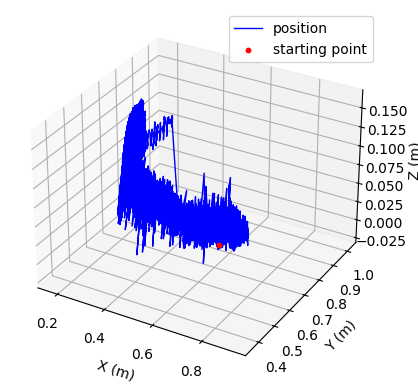

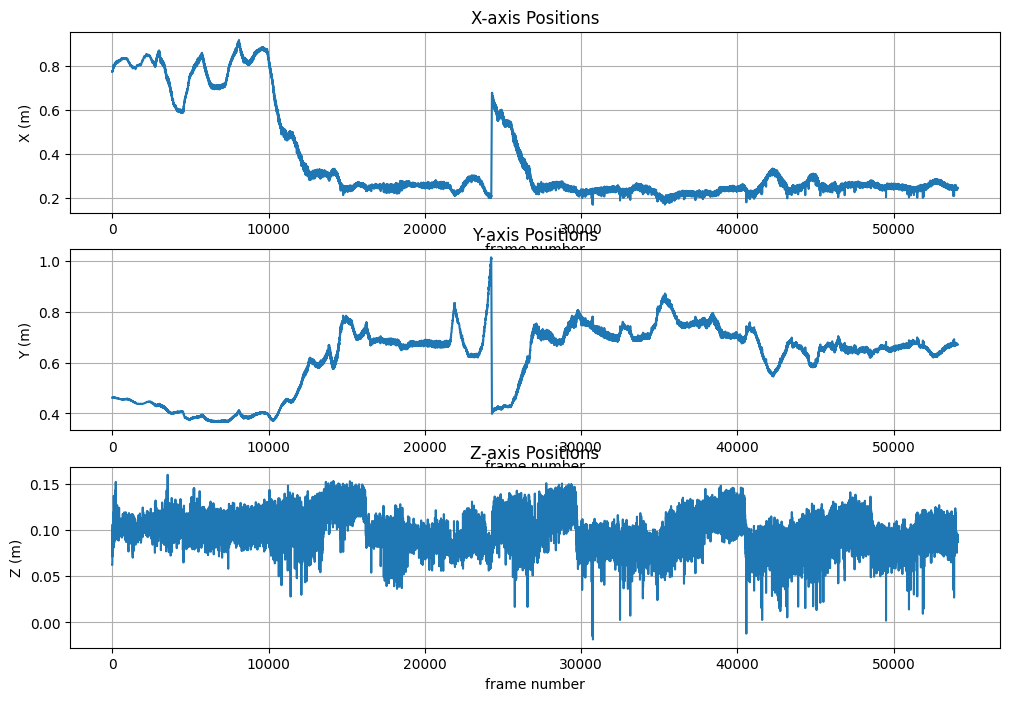

In [42]:
def visualize_xyz(x, y, z, t, time=False):         
    z_axis = t if time else z        

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, y, z_axis, color='blue', label='position', linewidth=1)
    ax.scatter(x[0], y[0], z_axis[0], color='red', s=10, label='starting point')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    zlabel = 'Frame number' if time else 'Z (m)'
    ax.set_zlabel(zlabel)
    ax.legend()
    
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, x)
    plt.title("X-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("X (m)")
    plt.grid()
    
    plt.subplot(3, 1, 2)
    plt.plot(t, y)
    plt.title("Y-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("Y (m)")
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.plot(t, z)
    plt.title("Z-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("Z (m)")
    plt.grid()
    plt.show()

    plt.show()
visualize_xyz(pose_datas.x, pose_datas.y, pose_datas.z, pose_datas.t, False)

In [12]:
def double_3D_plot(plot_data):
    off1 = plot_data['Offset_motor_1']
    off2 = plot_data['Offset_motor_2']
    amp1 = plot_data['Amp_motor_1']
    amp2 = plot_data['Amp_motor_2']
    phb_diff = plot_data['Phase_difference']
    speeds = plot_data['Speed']
    
    fig = plt.figure(figsize=(12, 7))  # Adjust the figure size for better spacing

    # Left subplot
    ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 columns, 1st plot
    for i in range(len(off1)):
        ax1.scatter(off1[i], off2[i], phb_diff[i], s=speeds[i]*3000, c=amp1[i], marker='o', cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Offset motor 1')
    ax1.set_ylabel('Offset motor 2')
    ax1.set_zlabel('Phase difference')
    ax1.set_title('Graph 1')
    cbar1 = plt.colorbar(ax1.collections[0], ax=ax1, pad=0.1)
    cbar1.set_label('Speed')

    # Right subplot
    ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 columns, 2nd plot
    for i in range(len(off1)):
        ax2.scatter(off1[i], off2[i], phb_diff[i], s=speeds[i]*3000, c=amp2[i], marker='o', cmap='viridis', alpha=0.8)
    ax2.set_xlabel('Offset motor 1')
    ax2.set_ylabel('Offset motor 2')
    ax2.set_zlabel('Phase difference')
    ax2.set_title('Graph 2')
    cbar2 = plt.colorbar(ax2.collections[0], ax=ax2, pad=0.1)
    cbar2.set_label('Speed')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# <ins> IMU Data</ins>


folder: 0-179
./cleanData/Snake/0-179
14708
2e-05 0.998
2e-05 0.998
2e-05 0.998
Max amplitude frequency: 12.313026924122926
Max amplitude frequency: 12.190644547185205
Max amplitude frequency: 12.190644547185205


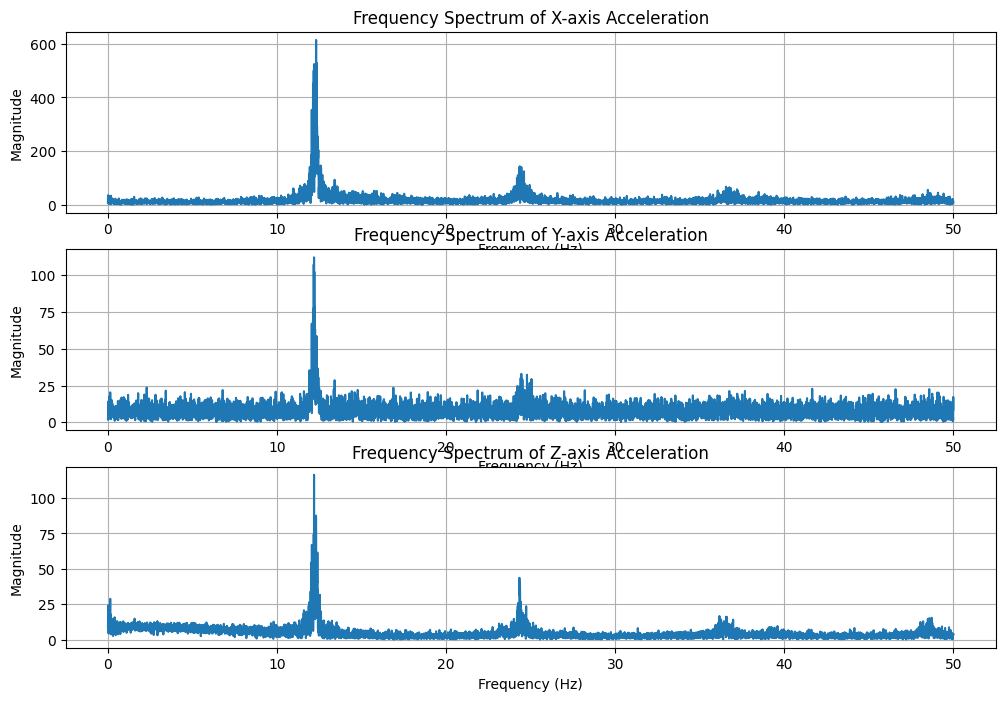

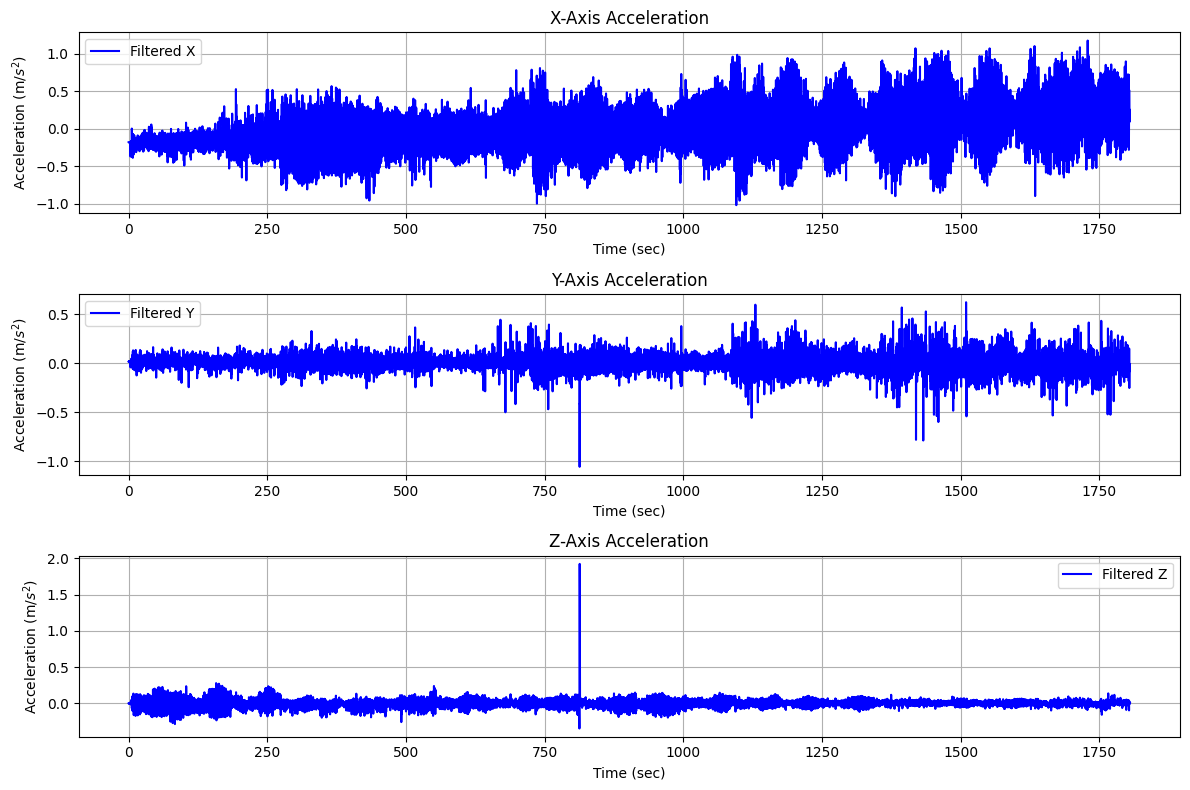

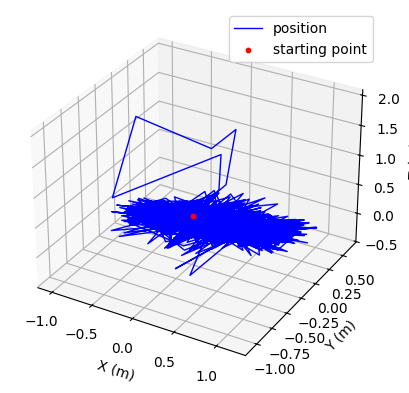

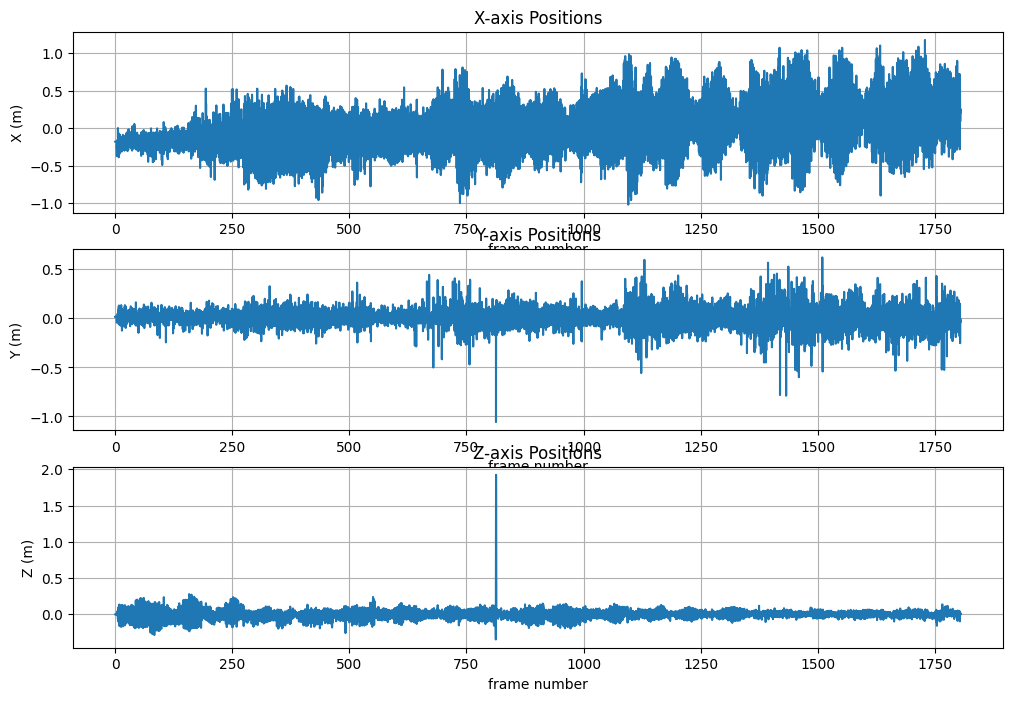

In [45]:
def load_IMU_data(file_path):
    data_dict = defaultdict(dict)

    # Regular expression to match the structure of each entry
    entry_pattern = re.compile(
        r"(?P<timestamp>\d+:\d+:\d+\.\d+)\s+"
        r"{Acceleration:\s+{Time:\s*(?P<acc_time>\d+),\s+Status:\s*(?P<acc_status>\d+),\s+Value:\s*\((?P<acc_values>[^)]+)\)},\s*"
        r"Gyroscope:\s+{Time:\s*(?P<gyro_time>\d+),\s+Status:\s*(?P<gyro_status>\d+),\s+Value:\s*\((?P<gyro_values>[^)]+)\)},\s*"
        r"Magnetic:\s+{Time:\s*(?P<mag_time>\d+),\s+Status:\s*(?P<mag_status>\d+),\s+Value:\s*\((?P<mag_values>[^)]+)\)},\s*"
        r"Gravity:\s+{Time:\s*(?P<grav_time>\d+),\s+Status:\s*(?P<grav_status>\d+),\s+Value:\s*\((?P<grav_values>[^)]+)\)},\s*"
        r"Rotation:\s+{Time:\s*(?P<rot_time>\d+),\s+Status:\s*(?P<rot_status>\d+),\s+Value:\s*\((?P<rot_values>[^)]+)\)}"
    )
    print(filepath)
    # Read the file line by line
    with open(file_path, 'r') as file:
        for line in file:
            match = entry_pattern.search(line)
            if match:
                timestamp = match.group("timestamp")
                # Organize sensor data into a nested dictionary
                data_dict[timestamp] = {
                    "Acceleration": {
                        "Time": int(match.group("acc_time")),
                        "Status": int(match.group("acc_status")),
                        "Value": tuple(map(float, match.group("acc_values").split(",")))
                    },
                    "Gyroscope": {
                        "Time": int(match.group("gyro_time")),
                        "Status": int(match.group("gyro_status")),
                        "Value": tuple(map(float, match.group("gyro_values").split(",")))
                    },
                    "Magnetic": {
                        "Time": int(match.group("mag_time")),
                        "Status": int(match.group("mag_status")),
                        "Value": tuple(map(float, match.group("mag_values").split(",")))
                    },
                    "Gravity": {
                        "Time": int(match.group("grav_time")),
                        "Status": int(match.group("grav_status")),
                        "Value": tuple(map(float, match.group("grav_values").split(",")))
                    },
                    "Rotation": {
                        "Time": int(match.group("rot_time")),
                        "Status": int(match.group("rot_status")),
                        "Value": tuple(map(float, match.group("rot_values").split(",")))
                    }
                }
    return data_dict

def low_pass_filter(data, low_cutoff, high_cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the given data.

    Parameters:
        data (array-like): The input data to filter.
        cutoff (float): The cutoff frequency of the filter (Hz).
        fs (float): The sampling frequency (Hz).
        order (int): The order of the filter.

    Returns:
        filtered_data (ndarray): The filtered data.
    """
    low = low_cutoff / (0.5 * fs)
    high = high_cutoff /(0.5 * fs)
    print(low, high)
    b, a = butter(order, [low, high], btype='band', analog=False)
    # b, a = butter(order, low, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def compute_position(data_dict, cutoffs):
    # Initialize lists for time, acceleration, velocity, and position
    timestamps = []
    accelerations = []

    # Extract timestamps and acceleration values
    for timestamp, sensors in data_dict.items():
        acc = sensors["Acceleration"]["Value"]
        if len(timestamps) != 0 and timestamp < timestamps[-1]:
            print(f"Skipped timestamps {len(timestamps)}")
            timestamps = []
            accelerations = []
        timestamps.append(timestamp)
        accelerations.append(acc)

    # Convert timestamps to seconds since start
    start_time = timestamps[0]
    time_in_seconds = [
        sum(float(x) * t for x, t in zip(ts.split(":"), [3600, 60, 1]))
        - sum(float(x) * t for x, t in zip(start_time.split(":"), [3600, 60, 1]))
        for ts in timestamps
    ]

    # Convert acceleration list to numpy array
    accelerations = np.array(accelerations)
    time_in_seconds = np.array(time_in_seconds)

    # Apply low-pass filter
    # sampling_frequency = 1 / np.mean(np.diff(time_in_seconds))  # Hz
    # print(sampling_frequency)
    sampling_frequency = 100

    filtered_accs = []
    for i, cutoff in enumerate(cutoffs):
        filtered_accs.append(low_pass_filter(accelerations[:, i], cutoff[0], cutoff[1], sampling_frequency))
    filtered_accelerations = np.column_stack(filtered_accs)

    # Integrate acceleration to find velocity (v = ∫a dt)
    velocities = integrate.cumulative_trapezoid(filtered_accelerations, time_in_seconds, axis=0, initial=0)

    # Integrate velocity to find position (s = ∫v dt)
    positions = integrate.cumulative_trapezoid(velocities, time_in_seconds, axis=0, initial=0)

    plot_fft = True
    if plot_fft:
        n = len(accelerations[:,0])  # Number of samples

        freqs = np.fft.rfftfreq(n, d=1/sampling_frequency)  # Frequency bins
        fft_magnitude_x = np.abs(np.fft.rfft(accelerations[:,0]))  
        fft_magnitude_y = np.abs(np.fft.rfft(accelerations[:,1]))  
        fft_magnitude_z = np.abs(np.fft.rfft(accelerations[:,2]))  
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_x)]}')
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_y)]}')
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_z)]}')

        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(freqs, fft_magnitude_x)
        plt.title("Frequency Spectrum of X-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        
        plt.subplot(3, 1, 2)
        plt.plot(freqs, fft_magnitude_y)
        plt.title("Frequency Spectrum of Y-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        
        plt.subplot(3, 1, 3)
        plt.plot(freqs, fft_magnitude_z)
        plt.title("Frequency Spectrum of Z-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        plt.show()

    # Plotting the filtered acceleration data
    plot_filtered = True
    if plot_filtered:
        plt.figure(figsize=(12, 8))

        # X-axis
        plt.subplot(3, 1, 1)
        # plt.plot(time_in_seconds, acc_x, label="Original X", color="red", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[0], label="Filtered X", color="blue")
        plt.title("X-Axis Acceleration")
        plt.ylabel("Acceleration (m/$s^2$)")
        plt.xlabel("Time (sec)")
        plt.legend()
        plt.grid()

        # Y-axis
        plt.subplot(3, 1, 2)
        # plt.plot(time_in_seconds, acc_y, label="Original Y", color="green", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[1], label="Filtered Y", color="blue")
        plt.title("Y-Axis Acceleration")
        plt.ylabel("Acceleration (m/$s^2$)")
        plt.xlabel("Time (sec)")
        plt.legend()
        plt.grid()

        # Z-axis
        plt.subplot(3, 1, 3)
        # plt.plot(time_in_seconds, acc_z, label="Original Z", color="purple", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[2], label="Filtered Z", color="blue")
        plt.title("Z-Axis Acceleration")
        plt.ylabel("Acceleration (m/$s^2$)")
        plt.xlabel("Time (sec)")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
        visualize_xyz(filtered_accs[0],filtered_accs[1],filtered_accs[2],time_in_seconds,False)
    return positions



dir = './cleanData/Snake'
# dir = './cleanData/2024.09.17/Kumoko'
for folder in os.listdir(dir):
    # if folder != '15.50.58':
    #     continue
    if folder == '1080-1259':
        break
    if os.path.splitext(folder)[1] != '':
        continue
    print(f'folder: {folder}')
    filepath = f'{dir}/{folder}'
    IMU_data = None
    for file in os.listdir(filepath):
        if file == "IMU.log":
            IMU_data = load_IMU_data(f'{filepath}/{file}')
            break
    print(len(IMU_data))
    positions = compute_position(IMU_data, ((0.001,50-0.1),)*3) 

    # Output positions
    """for i, pos in enumerate(positions):
        print(f"Position at t={i}: {pos}")
    
    prev_time = None
    for timestamp in IMU_data.keys():
        if prev_time is None:
            prev_time = timestamp
            continue
        print(IMU_data[timestamp])
        print(IMU_data[timestamp]['Gravity'])
        break
 """       
                    


clean path: ./cleanData/2025.01.07/Snake1/12.50.59
Row deleted for IMU log: 2, final size: 817
Row deleted for index 0: 1, final size: 817
Row deleted for index 1: 1, final size: 817
Row deleted for index 2: 2, final size: 817
Row deleted for index 3: 2, final size: 817
--- 1771.1064932346344 seconds ---
IMU.log
./cleanData/Snake/plot data.log
817
2e-05 0.998
2e-05 0.998
2e-05 0.998
Max amplitude frequency: 0.12239902080783353
Max amplitude frequency: 25.58139534883721
Max amplitude frequency: 0.24479804161566707


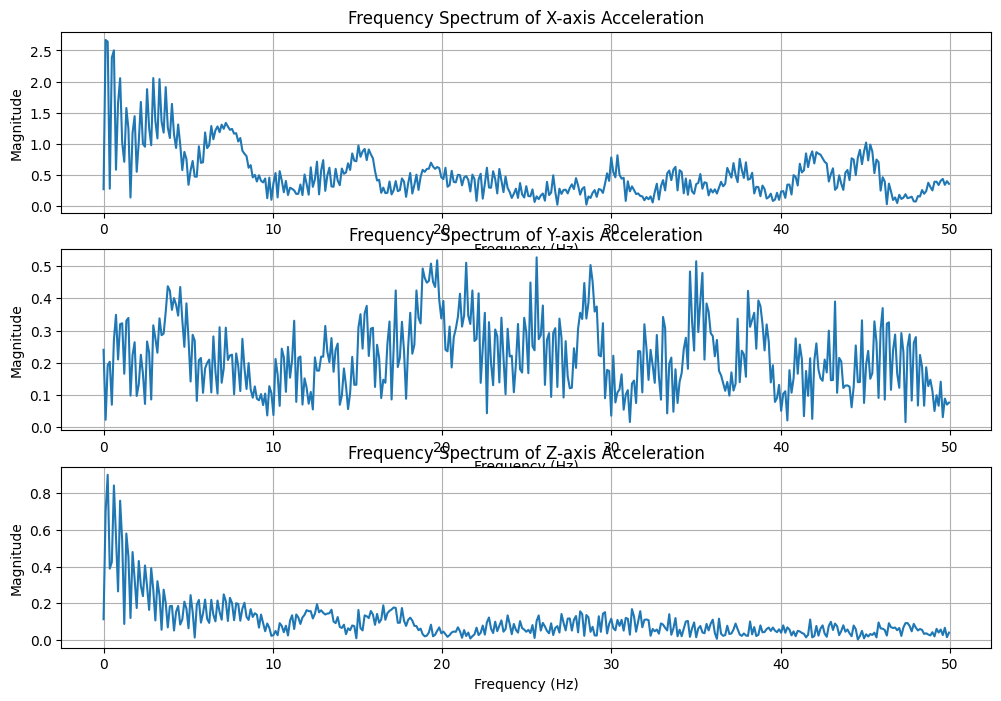

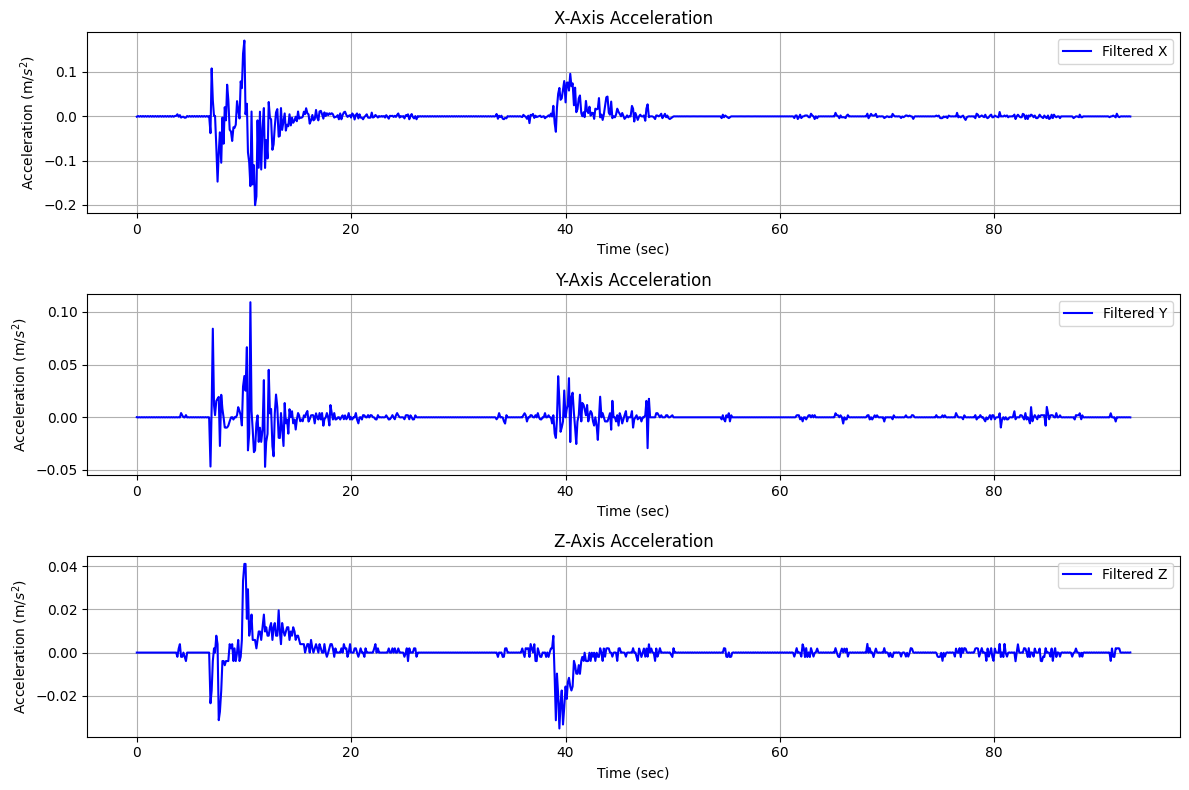

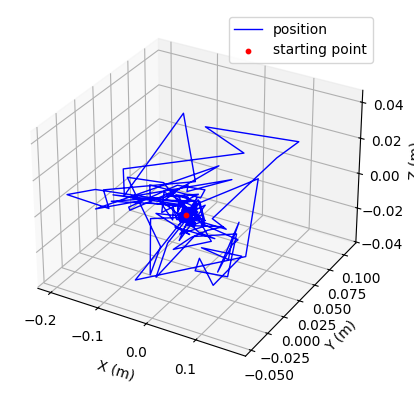

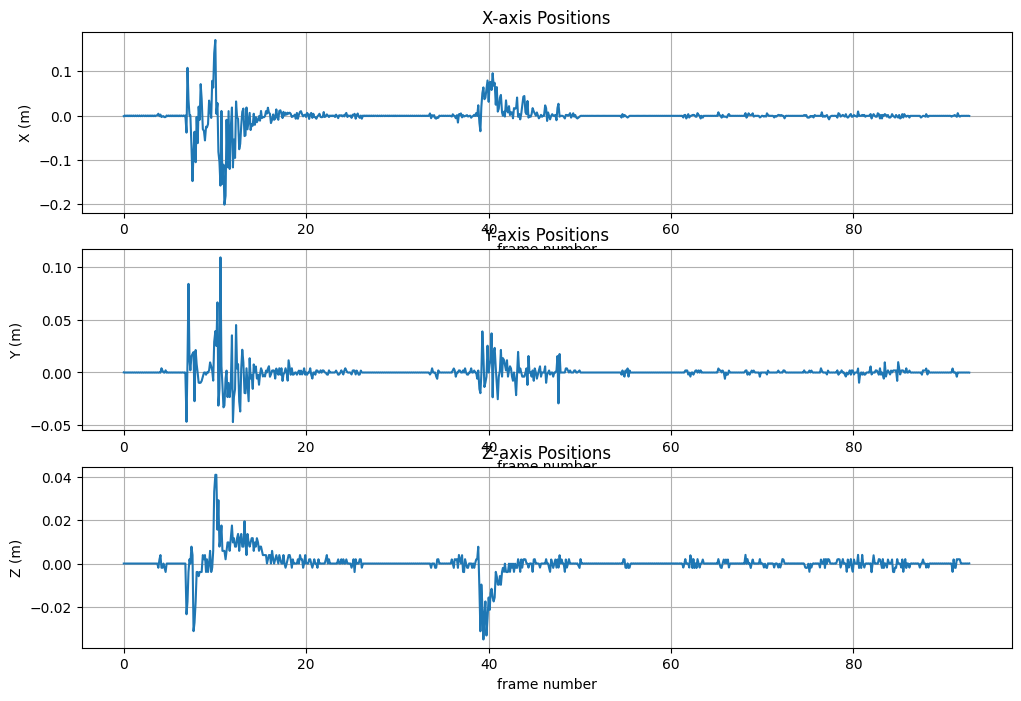

In [44]:
path = './SessionLogs/2025.01.07/Snake1/12.50.59'
clean(path, False)
path = './cleanData/2025.01.07/Snake1/12.50.59'
for file in os.listdir(path):
    print(file)
    if file == "IMU.log":
        IMU_data = load_IMU_data(f'{path}/{file}')
        
    print(len(IMU_data))
    # for low in range(20, 100, 1):
    #     low = low/10
    #     if not low:
    #         continue
    #     positions = compute_position(IMU_data, ((low,low+0.1),)*3) 
    positions = compute_position(IMU_data, ((0.001,50-0.1),)*3) 
    break

